In [1]:
# %%
import re
import os
import string
import numpy as np
import pandas as pd

from tensorflow.python.keras import backend as K
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet import ResNet152

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-02-12 20:01:56.783629: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-12 20:01:56.783646: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-12 20:01:56.783652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-12 20:01:56.783686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 20:01:56.783890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
!pip install sentence-transformers

In [4]:
# from keras.initializers import Constant
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Concatenate, Embedding, LSTM, Dropout, Bidirectional, Layer, InputSpec, Dot, Activation, Multiply

# %%
from sentence_transformers import SentenceTransformer, util
from PIL import Image

In [5]:
!ls

Aspect_Complain_web_entity_clip.csv
ICDAR_data.csv
Label_identification.ipynb
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
complaint_reviews_final1.csv
formatted_icdar.csv
image_folder
local_icdar.csv
multi_aspect_classification_vae.py
multi_aspect_detection_text_image_with_blip.h5
review_embeddings.pkl
save_dir
vae_gru.pt
vae_gru_final.py


In [6]:
sentence_model = SentenceTransformer('paraphrase-mpnet-base-v2')

# %%
dataset = pd.read_csv("./Aspect_Complain_web_entity_clip.csv")
#dataset.drop(columns = ['Complaint Overall', 'Emotion Overall', 'Sentiment Overall','Emotion.0', 'Emotion.1', 'Emotion.2', 'Emotion.3', 'Comments'], inplace = True)
#dataset = dataset.iloc[0:1096,:]

In [7]:
dataset.head()

,Unnamed: 0,Domain,Complaint/ Opinion,Over-all_Complaint Label,Aspects_1,Complaint_1,Cause_1,Aspect_2,Complaint_2,Cause_2,Aspect_3,Complaint_3,Cause_3,Complaint_Cause,Severity level,Sentiment,Emotion,Image Link,Web Entity
0,0,Customer Service,https://consumercomplaintscourt.com/ifb-washin...,1,Technical Issue,1.0,IFB washing machine,NaN,NaN,NaN,NaN,NaN,NaN,IFB washing machine,accusation,negative,anger,../BART/BART/5839.png,['Plastic bag' 'Plastic' 'Bag' 'Product' 'Font...
1,1,Retail Banking,https://consumercomplaintscourt.com/i-want-to-...,1,Banking,1.0,want to forclose my dhani one freedom card at ...,NaN,NaN,NaN,NaN,NaN,NaN,I want to forclose my dhani one freedom card a...,Non-Complaint,Neutral,other,../BART/BART/1821.png,['Line' 'Font' 'Product' 'Brand' 'Text' 'Atmos...
2,2,Credit card,@ICICIBank @ICICIBank_Care wrist service from ...,1,Delay Response,1.0,not able to refresh the service.,NaN,NaN,NaN,NaN,NaN,NaN,not able to refresh the service.,Disapproval,negative,sadness,./output/2.jpg,['Product design' 'Screenshot' 'Design' nan 'G...
3,3,Credit card,@ICICIBank_Care @amazonpay can you help in get...,1,General Query,1.0,getting Amazon pay ICICI credit card,miscellaneous information,NaN,NaN,NaN,NaN,NaN,can you help in getting Amazon pay ICICI credi...,No explicit reproach,neutral,other,./output/3.jpg,['Black-and-white' 'Screenshot' 'Line' 'Font' ...
4,4,Credit card,@ICICIBank_Care @ICICIBank it's been more than...,1,Delay Response,1.0,my refund is not credited to my credit card,NaN,NaN,NaN,NaN,NaN,NaN,my refund is not credited to my credit card,No explicit reproach,negative,sadness,./output/4.jpg,['Black-and-white' 'Screenshot' 'Line' 'Font' ...


In [8]:
data = pd.read_csv("local_icdar.csv")
data = data.dropna(subset=['Image', 'Aspect_1'])
data = data.reset_index()

In [9]:
data.head(10)

,index,Unnamed: 0,Domain,Sub Domain,Product Title,Product Link,Review Content,Image,Aspect_1,Label_1,...,Label_3,Cause_3,Aspect_4,Label_4,Cause_4,Aspect_5,Label_5,Cause_5,Over All label,Summary
0,0,0,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,I have been using this phone from last one wee...,image_folder/image_0.jpg,Display,0,...,1.0,Front camera Ip rating.,NaN,NaN,NaN,NaN,NaN,NaN,1,Comprehensive Summary: OnePlus 11 5G - Navigat...
1,1,1,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,The media could not be loaded. Everything func...,image_folder/image_1.jpg,Media,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,2,2,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,Over all Good Experience but this phone is so ...,image_folder/image_2.jpg,Product_Quality,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,3,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_3.jpg,Display,1,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
4,4,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_4.jpg,Display,1,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
5,5,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_5.jpg,Display,1,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
6,6,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_6.jpg,Display,1,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
7,7,4,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,The media could not be loaded.,image_folder/image_7.jpg,Media,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
8,9,6,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,"A wonderful marble finish, superfast charging,...",image_folder/image_9.jpg,Product_Quality,0,...,0.0,great portrait shots,Storage,0.0,16gb of RAM and fast 4.0 storage,Software,0.0,and 5 years of software update promise,0,NaN
9,10,7,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,Purchased this product after lot of hesitation...,image_folder/image_10.jpg,Display,0,...,0.0,OP 11 is clear winner you can rely on it as a ...,Product_Quality,0.0,top notch is with OP 11 & OP 11 is clear winner,NaN,NaN,NaN,0,NaN


In [10]:
dataset = data

In [11]:
#dataset.rename(columns = {' ': 'Domain'}, inplace = True)
dataset = dataset.drop('Unnamed: 0',axis = 1)
# dataset = dataset.drop('Unnamed: 0.1',axis = 1)
dataset.columns

Index(['index', 'Domain', 'Sub Domain', 'Product Title', 'Product Link',
       'Review Content', 'Image', 'Aspect_1', 'Label_1', 'Cause_1', 'Aspect_2',
       'Label_2', 'Cause_2', 'Aspect_3', 'Label_3', 'Cause_3', 'Aspect_4',
       'Label_4', 'Cause_4', 'Aspect_5', 'Label_5', 'Cause_5',
       'Over All label', 'Summary'],
      dtype='object')

In [12]:
# %%
dataset.head(10)

,index,Domain,Sub Domain,Product Title,Product Link,Review Content,Image,Aspect_1,Label_1,Cause_1,...,Label_3,Cause_3,Aspect_4,Label_4,Cause_4,Aspect_5,Label_5,Cause_5,Over All label,Summary
0,0,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,I have been using this phone from last one wee...,image_folder/image_0.jpg,Display,0,Display Performance,...,1.0,Front camera Ip rating.,NaN,NaN,NaN,NaN,NaN,NaN,1,Comprehensive Summary: OnePlus 11 5G - Navigat...
1,1,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,The media could not be loaded. Everything func...,image_folder/image_1.jpg,Media,1,The media could not be loaded,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,2,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,Over all Good Experience but this phone is so ...,image_folder/image_2.jpg,Product_Quality,0,Over all Good Experience,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_3.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
4,4,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_4.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
5,5,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_5.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
6,6,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_6.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
7,7,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,The media could not be loaded.,image_folder/image_7.jpg,Media,1,could not be loaded,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
8,9,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,"A wonderful marble finish, superfast charging,...",image_folder/image_9.jpg,Product_Quality,0,A wonderful marble finish,...,0.0,great portrait shots,Storage,0.0,16gb of RAM and fast 4.0 storage,Software,0.0,and 5 years of software update promise,0,NaN
9,10,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,Purchased this product after lot of hesitation...,image_folder/image_10.jpg,Display,0,OP11 is more eye friendly & cherry on top is D...,...,0.0,OP 11 is clear winner you can rely on it as a ...,Product_Quality,0.0,top notch is with OP 11 & OP 11 is clear winner,NaN,NaN,NaN,0,NaN


In [13]:
dataset.keys()

Index(['index', 'Domain', 'Sub Domain', 'Product Title', 'Product Link',
       'Review Content', 'Image', 'Aspect_1', 'Label_1', 'Cause_1', 'Aspect_2',
       'Label_2', 'Cause_2', 'Aspect_3', 'Label_3', 'Cause_3', 'Aspect_4',
       'Label_4', 'Cause_4', 'Aspect_5', 'Label_5', 'Cause_5',
       'Over All label', 'Summary'],
      dtype='object')

In [14]:
# unique_count = dataset['Domain'].unique()
# print(unique_count)

unique_counts = dataset['Domain'].value_counts()

# Print the results
print(unique_counts)

Domain
Mobile         670
Smart Watch    666
Airdopes       628
Cosmetics      430
Shoe           406
Stove          375
Trolley        313
Laptop         163
Purse          163
DuoPods        112
Watch           92
Name: count, dtype: int64


In [15]:
!ls

Aspect_Complain_web_entity_clip.csv
ICDAR_data.csv
Label_identification.ipynb
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
complaint_reviews_final1.csv
formatted_icdar.csv
image_folder
local_icdar.csv
multi_aspect_classification_vae.py
multi_aspect_detection_text_image_with_blip.h5
review_embeddings.pkl
save_dir
vae_gru.pt
vae_gru_final.py


In [16]:
# %%
images_path = './'+dataset['Image']

In [17]:
images_path[8]

'./image_folder/image_9.jpg'

In [18]:
# %% [markdown]
# ## Getting data into lists

# %%
dataset.iloc[2,0]

2

In [19]:
# %%
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           4021 non-null   int64  
 1   Domain          4018 non-null   object 
 2   Sub Domain      4016 non-null   object 
 3   Product Title   4021 non-null   object 
 4   Product Link    4021 non-null   object 
 5   Review Content  3906 non-null   object 
 6   Image           4021 non-null   object 
 7   Aspect_1        4021 non-null   object 
 8   Label_1         3911 non-null   object 
 9   Cause_1         3908 non-null   object 
 10  Aspect_2        2451 non-null   object 
 11  Label_2         2455 non-null   object 
 12  Cause_2         2453 non-null   object 
 13  Aspect_3        1439 non-null   object 
 14  Label_3         1421 non-null   float64
 15  Cause_3         1429 non-null   object 
 16  Aspect_4        866 non-null    object 
 17  Label_4         860 non-null    f

In [20]:
dataset.keys()

Index(['index', 'Domain', 'Sub Domain', 'Product Title', 'Product Link',
       'Review Content', 'Image', 'Aspect_1', 'Label_1', 'Cause_1', 'Aspect_2',
       'Label_2', 'Cause_2', 'Aspect_3', 'Label_3', 'Cause_3', 'Aspect_4',
       'Label_4', 'Cause_4', 'Aspect_5', 'Label_5', 'Cause_5',
       'Over All label', 'Summary'],
      dtype='object')

In [21]:
# %%
dataset['Domain'] = dataset['Domain'].astype(str)
dataset['Review Content'] = dataset['Review Content'].astype(str)

In [22]:
dataset.head()

,index,Domain,Sub Domain,Product Title,Product Link,Review Content,Image,Aspect_1,Label_1,Cause_1,...,Label_3,Cause_3,Aspect_4,Label_4,Cause_4,Aspect_5,Label_5,Cause_5,Over All label,Summary
0,0,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,I have been using this phone from last one wee...,image_folder/image_0.jpg,Display,0,Display Performance,...,1.0,Front camera Ip rating.,NaN,NaN,NaN,NaN,NaN,NaN,1,Comprehensive Summary: OnePlus 11 5G - Navigat...
1,1,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,The media could not be loaded. Everything func...,image_folder/image_1.jpg,Media,1,The media could not be loaded,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,2,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,Over all Good Experience but this phone is so ...,image_folder/image_2.jpg,Product_Quality,0,Over all Good Experience,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,3,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_3.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN
4,4,Mobile,OnePlus,"OnePlus 11 5G (Eternal Green, 16GB RAM, 256GB ...",https://www.amazon.in/OnePlus-Eternal-Green-25...,After using of 2 months I have seen dead spots...,image_folder/image_4.jpg,Display,1,After using of 2 months I have seen dead spots...,...,1.0,before investing a 60k think about it Just ope...,Consumer_Safety,1.0,As per the support and customer experience did...,NaN,NaN,NaN,1,NaN


In [23]:
import pandas as pd
from collections import Counter

# Assuming df is your pandas DataFrame
# For example, let's say you have columns 'column1' and 'column2'
# You can replace them with the actual column names in your DataFrame

df = dataset

# Select the columns you are interested in
selected_columns = ['Aspect_1', 'Aspect_2', 'Aspect_3', 'Aspect_4', 'Aspect_5']

# Concatenate the values of selected columns into a single Series
concatenated_series = pd.concat([df[col] for col in selected_columns])

# Create a Counter object
value_counter = Counter(concatenated_series)

sorted_counter = dict(sorted(value_counter.items(), key=lambda x: x[1], reverse=True))


# Print the count of each unique value
for value, count in sorted_counter.items():
    print(f"{value}: {count}")


nan: 10898
Product_Quality: 2476
Cost: 988
Performance: 924
Battery: 845
Feedback: 622
Speaker: 584
Customer_Service: 479
Media: 460
Display: 434
Camera: 367
Noise: 226
Network: 158
Function: 151
Weight: 129
Software: 99
Charging: 50
User_Interface: 39
Security: 38
Color: 28
Storage: 18
Hardware: 14
Packaging: 13
Look: 12
S_Pen: 10
service: 8
feedback: 7
Size: 5
User Experience: 4
Consumer_Safety: 4
Review: 3
PRoduct_Quality: 3
media: 3
Product_Quantity: 3
weight: 2
Texture: 1


In [24]:
dataset.keys()

Index(['index', 'Domain', 'Sub Domain', 'Product Title', 'Product Link',
       'Review Content', 'Image', 'Aspect_1', 'Label_1', 'Cause_1', 'Aspect_2',
       'Label_2', 'Cause_2', 'Aspect_3', 'Label_3', 'Cause_3', 'Aspect_4',
       'Label_4', 'Cause_4', 'Aspect_5', 'Label_5', 'Cause_5',
       'Over All label', 'Summary'],
      dtype='object')

In [25]:
num_of_labels = 9

In [26]:
# %%
def get_title_review_comb(X_reviews):
    title_review_comb = []
    for i in range(X_reviews.shape[0]):
        if(str(type(X_reviews.iloc[i,3])) == "<class 'str'>" and str(type(X_reviews.iloc[i,5])) == "<class 'str'>"):
          title_review_comb.append(str(X_reviews.iloc[i,3])+" "+str(X_reviews.iloc[i,5]))
        else:
          # print(i)
          title_review_comb.append(X_reviews.iloc[i,3])

    text_reviews = []
    for i in range(X_reviews.shape[0]):
        words = re.split(r'\W+', title_review_comb[i])

        words = [word.lower() for word in words]
        text = ' '.join(words)
        words = text.split()
        text = ' '.join(words)
        text_reviews.append(text)

    return text_reviews

# def check_aspect_comp(aspect,complaint_label,j):
#   aspects = []
#   comp_labels = []
#   for i in [0,1,2]:
#     val1 = aspect[i][j]
#     val2 = complaint_label[i][j]
#     if(str(val1) == 'nan') or val1 == ' ':
#       continue
#     elif(val1 == 'fabric'):
#       aspects.append('quality')
#     else:
#       aspects.append(val1)
#     comp_labels.append(val2)

#   return aspects,comp_labels

def check_aspect_comp(aspect,complaint_label,j):
  asp = []
  comp_labels = []
  for i in [0,1,2]:
    val = aspect[i][j]
    val2 = complaint_label[i][j]
    if(str(val) != 'nan'):
      val = str(val).lower().strip()
    if(str(val) == 'nan'):
      continue

    elif val in ['battery', 'charging']:
      asp.append('Energy_Reservior')

    elif val in ['camera']:
      asp.append('Camera')

    elif val in ['color']:
      asp.append('Others')

    elif val in ['customer_service']:
      asp.append('Customer_Service')

    elif val in ['cost']:
      asp.append('Price')

    elif val in ['product_quality', 'product_quantity']:
      asp.append('Product_Quality')

    elif val in ['user experience', 'feedback', 'review']:
      asp.append('Feedback')

    elif val in ['security', 'consumer_safety']:
      asp.append('Others')

    elif val in ['display']:
      asp.append('Display')

    elif val in ['hardware', 'software']:
      asp.append('Others')

    elif val in ['media', 'function', 'speaker', 'user_interface', 'size', 'noise', 's_pen', 'texture']:
      asp.append('Functionality')

    elif val in ['packaging', 'look', 'texture']:
      asp.append('Others')

    elif val in ['service']:
      asp.append('Others')

    elif val in ['weight', 'storage']:
      asp.append('Others')
        
        
    # elif val in ['freedback','feeedback','feedbck','feedaback','fedback','feedabck','feedback','personal opinion','personal opinion,','general opinion','advise','genera review','general review']:
    #   asp.append('review')
    # elif val in ['miscelllaneous information','miscellaneous inforamation','miscellaneous inforation','misceallneous information','miscellaneous information, inflation','misellaneous infromation','miscelleneos information','miscellaneous information','miscellaneous','miscellameous information','miscellaneus information','misellaneous information','miscelaneous information','misceklaneous information','miscellaneous iformation','misceallaneous information','financial advertisement','financial advertiement','financial advertisemnt']:
    #   asp.append('misc_info')
    # elif val in ['delay, response','delay resoponse','delay respose','delay response','dealy response','delay resonse','delay response,','delay reponse','apologise']:
    #   asp.append('provider_response')
    # elif val in ['payment','paymet','payent issue','payment issue','payment issue, bank issue','payment failure','payment failure, miscellaneous information','banking','bankinhg','bank issue','net banking','bank issue, harassment','internet banking','refund issue']:
    #   asp.append('net_banking_issue')
    # # elif val in ['banking','bankinhg','bank issue','net banking','bank issue, harassment','internet banking']:
    # #   asp.append('banking_issue')
    # elif val in ['haraasment','harrasment','harassment','harrashment','fruad','fraud','manipulation']:
    #   asp.append('consumer_safety')
    # # elif val in ['fruad','fraud']:
    # #   asp.append('fraud')
    # elif val in ['trade balance','news','dept collection','debt collection','exports']:
    #   asp.append('financial_info')
    # # elif val in ['inflation']:
    # #   asp.append('inflation')
    # elif val in ['crdentials','credentials','credentials issue','credential','cedentials','credential related','technicality','techinicality','technical issue']:
    #   asp.append('credential_error')
    # elif val in ['finacial policy','financial policy','financial policies','financial poilicy','financial stability','financial gain','inflation']:
    #   asp.append('financial_situation')
    # # elif val in ['apologise']:
    # #   asp.append('apologise')
    # # elif val in ['dept collection','debt collection']:
    # #   asp.append('debt_collection')
    # # elif val in ['equal taxation']:
    # #   asp.append('equal_taxation')
    # elif val in ['genearl query','general qurey','general query','genral query','genaral query','general qurery','tax increases','equal taxation']:
    #   asp.append('general_query')
    # # elif val in ['personal opinion','personal opinion,','general opinion','advise','genera review','general review']:
    # #   asp.append('personal_opinion')
    # # elif val in ['financial stability']:
    # #   asp.append('financial_stability')
    # # elif val in ['financial gain']:
    # #   asp.append('financial_gain')
    # # elif val in ['news']:
    # #   asp.append('news')
    # # elif val in ['manipulation']:
    # #   asp.append('manipulation')
    # # elif val in ['financial advertisement','financial advertiement','financial advertisemnt']:
    # #   asp.append('financial_advertisement')
    # # elif val in ['exports']:
    # #   asp.append('exports')
    # # elif val in ['tax increases','equal taxation']:
    # #   asp.append('tax_implication')
    # # elif val in ['technicality','techinicality','technical issue']:
    # #   asp.append('technical_issue')
    # # elif val in ['debt collection']:
    # #   asp.append('debt collection')
    # # elif val in ['refund issue']:
    # #   asp.append('refund_issue')
    # # else:
    # #   print(val)
    else:
      asp.append('No_Aspects')
    comp_labels.append(val2)
  return asp,comp_labels


def get_labels(df):
    aspect = [list(df['Aspect_1']), list(df['Aspect_2']), list(df['Aspect_3']), list(df['Aspect_4']), list(df['Aspect_5'])]
    complaint_label = [list(df['Label_1']), list(df['Label_2']), list(df['Label_3']), list(df['Label_4']), list(df['Label_5'])]
    comp_labels = []
    aspects = []

    for i in range(df.shape[0]):
        out = check_aspect_comp(aspect,complaint_label,i)
        aspects.append(out[0])
        comp_labels.append(out[1])

    return aspects, comp_labels

def get_web_entities(dataset):
    web_entities = []
    for mul_entities in list(dataset['Web_entities']):
      lables_list = (re.sub("[^a-zA-Z0-9,.)]", " ", mul_entities)).split(',')
      # print(lables_list)
      lables_list_mod = []
      for label in lables_list:
        label_mod = " ".join(label.split())
        # print(label_mod)
        if(label_mod == ''):
          continue
        lables_list_mod.append(label_mod.lower())

      web_entities.append(lables_list_mod)

    return web_entities


text_review = get_title_review_comb(dataset)
#web_entities = get_web_entities(dataset)
aspect_labels, complaint_labels = get_labels(dataset)

print(len(aspect_labels))
print(len(complaint_labels))
print(len(text_review))
#print(len(web_entities))
print(len(images_path))

4021
4021
4021
4021


In [27]:
# %%
complaint_labels[3][1]

'1'

In [28]:
# %%
for i in range(len(complaint_labels)):
  for j in range(len(complaint_labels[i])):
    if(str(complaint_labels[i][j]) == 'nan'):
      complaint_labels[i][j] = 0.0

In [29]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [30]:
for i in range(len(complaint_labels)):
  for j in range(len(complaint_labels[i])):
      if is_float(complaint_labels[i][j]):
        complaint_labels[i][j] = int(complaint_labels[i][j])
      else:
          complaint_labels[i][j] = int(1)

In [31]:
# %%
for item in complaint_labels:
    print(item)

[0, 0, 1]
[1, 0]
[0, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
[0, 0, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[1, 0, 0]
[1, 1]
[1, 1]
[1, 1]
[0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 1, 1]
[0, 1, 1]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 0, 0]
[1, 1]
[1, 1]
[1, 1]
[1, 0, 0]
[1, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1]
[0, 0, 0]
[0

In [32]:
# %%
# for each of the aspect_labels find the number of complaints and non complaint

comp_dict = {}
for i in range(len(aspect_labels)):
    for j in range(len(aspect_labels[i])):
        if aspect_labels[i][j] not in comp_dict:
            comp_dict[aspect_labels[i][j]] = complaint_labels[i][j]
        comp_dict[aspect_labels[i][j]] += complaint_labels[i][j]
print(comp_dict)

{'Display': 61, 'Energy_Reservior': 228, 'Camera': 46, 'Functionality': 635, 'No_Aspects': 291, 'Product_Quality': 556, 'Others': 87, 'Customer_Service': 266, 'Feedback': 135, 'Price': 141}


In [33]:
# %%
review_aspect_merged = []
images_path_new = []
comp_labels = []
# for r,a,c,i in zip(text_review, aspect_labels, complaint_labels, images_path):
#     for aspect,complaint in zip(a,c):
#         r_a = aspect+' [SEP] '+r
#         review_aspect_merged.append(r_a)
#         comp_labels.append(complaint)
#         images_path_new.append(i)
merged_aspect = []
for item in aspect_labels:
  temp = ""
  for j in item:
    temp = temp + " " + j
  merged_aspect.append(temp)
for i in range(len(text_review)):
    review_aspect_merged.append(text_review[i])
    comp_labels.append(aspect_labels[i])
    images_path_new.append(images_path[i])

print(len(review_aspect_merged))
print(len(images_path_new))
print(len(comp_labels))

4021
4021
4021


In [34]:
# %%
from collections import Counter
def get_labels_and_frequencies(aspects):
    label_freqs = Counter()
    data_labels = aspects
    if type(data_labels[0]) == list:
        for label_row in data_labels:
            label_freqs.update(label_row)
    else:
        label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

aspect_label, aspect_label_freqs = get_labels_and_frequencies(aspect_labels)
# aspect_label_1, aspect_label_freqs_1 = get_labels_and_frequencies(aspect_label_new)
# aspect_label, aspect_label_freqs = get_labels_and_frequencies(aspect_label_final)
print(aspect_label_freqs)
# print(aspect_label_freqs_1)
# print(aspect_label_freqs_2)

Counter({'Product_Quality': 2366, 'Functionality': 1313, 'No_Aspects': 918, 'Price': 870, 'Energy_Reservior': 653, 'Feedback': 466, 'Customer_Service': 394, 'Display': 359, 'Camera': 288, 'Others': 284})


In [35]:
# %%
# Delete all the text reviews from review_text_merged which has either no_aspect or financial_situation as aspect
# Delete the corresponding image path and complaint label
review_aspect_merged_new = []
images_path_new_new = []
comp_labels_new = []
aspect_label_new = []
for r,a,c,i in zip(review_aspect_merged, aspect_labels, complaint_labels, images_path_new):
    if('No_Aspects' not in a):
        review_aspect_merged_new.append(r)
        comp_labels_new.append(c)
        images_path_new_new.append(i)
        aspect_label_new.append(a)

In [36]:
# %%
# Repeat the sample for provider_response 2 times and net_banking_issue 3 times and change the complaint label, image_path_new_new, aspect_label_new accordingly
review_aspect_final = []
images_path_final = []
comp_labels_final = []
aspect_label_final = []
for r,a,c,i in zip(review_aspect_merged_new, aspect_label_new, comp_labels_new, images_path_new_new):
    if('Display' in a):
        for j in range(4):
            #print("yes")
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)
    if('Energy_Reservior' in a):
        for j in range(3):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)
    if('Camera' in a):
        for j in range(4):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)
    if('Customer_Service' in a):
        for j in range(4):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)
    if('Feedback' in a):
        for j in range(4):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)

    if('Functionality' in a):
        for j in range(2):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)

    if('Price' in a):
        for j in range(2):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)

    if('Others' in a):
        for j in range(4):
            review_aspect_final.append(r)
            comp_labels_final.append(c)
            images_path_final.append(i)
            aspect_label_final.append(a)
    
    else:
        review_aspect_final.append(r)
        comp_labels_final.append(c)
        images_path_final.append(i)
        aspect_label_final.append(a)

In [37]:
# %%
review_aspect_merged = review_aspect_final
images_path_new = images_path_final
comp_labels = comp_labels_final
aspect_label = aspect_label_final

In [38]:
review_aspect_final = review_aspect_merged
images_path_final = images_path_new
comp_labels_final = comp_labels
aspect_label_final = aspect_label

In [39]:
print(len(aspect_label_final))
print(len(comp_labels_final))
print(len(images_path_final))
print(len(review_aspect_final))

13474
13474
13474
13474


In [40]:
# %%
complaint_labels = comp_labels_final

In [41]:
# %% [markdown]
# ## Encoding text and images

In [42]:
# # %%
# sentence_model.max_seq_length = 512
# review_embeddings = []
# for review in review_aspect_merged:
#   text_emb = sentence_model.encode(review)
#   review_embeddings.append(text_emb)

In [43]:
# import pickle

# # Assuming review_embeddings is a list of numerical data or arrays

# # Specify the file path where you want to save the embeddings
# file_path = "review_embeddings.pkl"

# # Writing the embeddings to a Pickle file
# with open(file_path, 'wb') as pickle_file:
#     pickle.dump(review_embeddings, pickle_file)


In [44]:
import pickle

# Specify the file path where you saved the embeddings
file_path = "review_embeddings.pkl"

# Reading the embeddings from the Pickle file
with open(file_path, 'rb') as pickle_file:
    review_embeddings = pickle.load(pickle_file)

In [45]:
# %%
def image_preprocessing(path):
    #print(path)
    img = keras_image.load_img(path, target_size=(224, 224), interpolation='bicubic')
    img = keras_image.img_to_array(img)
    img = img//255.0
    return img

In [46]:
type(images_path_new[0])

str

In [47]:
images = []
for img_path in images_path_new:
  img = image_preprocessing(img_path)
  images.append(img)

images_list_new = []
for a,i in zip(aspect_label_final, images):
    for aspect in a:
        images_list_new.append(i)

In [48]:
# %%
# Count the distinct labels in the aspect labels
aspect_label, aspect_label_freqs = get_labels_and_frequencies(aspect_label_final)

In [49]:
# %%
aspect_label

['Display',
 'Energy_Reservior',
 'Camera',
 'Product_Quality',
 'Others',
 'Customer_Service',
 'Feedback',
 'Functionality',
 'Price']

In [50]:
# %%
# Count number of distinct aspect labels
aspect_labels_count = [item for sublist in aspect_label_final for item in sublist]
aspect_labels_count = list(set(aspect_labels_count))
print((aspect_labels_count))

['Functionality', 'Price', 'Customer_Service', 'Camera', 'Energy_Reservior', 'Others', 'Feedback', 'Product_Quality', 'Display']


In [51]:
# %%
from collections import Counter
def get_labels_and_frequencies(aspects):
    label_freqs = Counter()
    data_labels = aspects
    if type(data_labels[0]) == list:
        for label_row in data_labels:
            label_freqs.update(label_row)
    else:
        label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

aspect_label, aspect_label_freqs = get_labels_and_frequencies(aspect_label_final)
print(aspect_label_freqs)

Counter({'Product_Quality': 6443, 'Functionality': 5384, 'Energy_Reservior': 3837, 'Price': 3684, 'Display': 2583, 'Feedback': 2578, 'Camera': 2211, 'Customer_Service': 2130, 'Others': 1694})


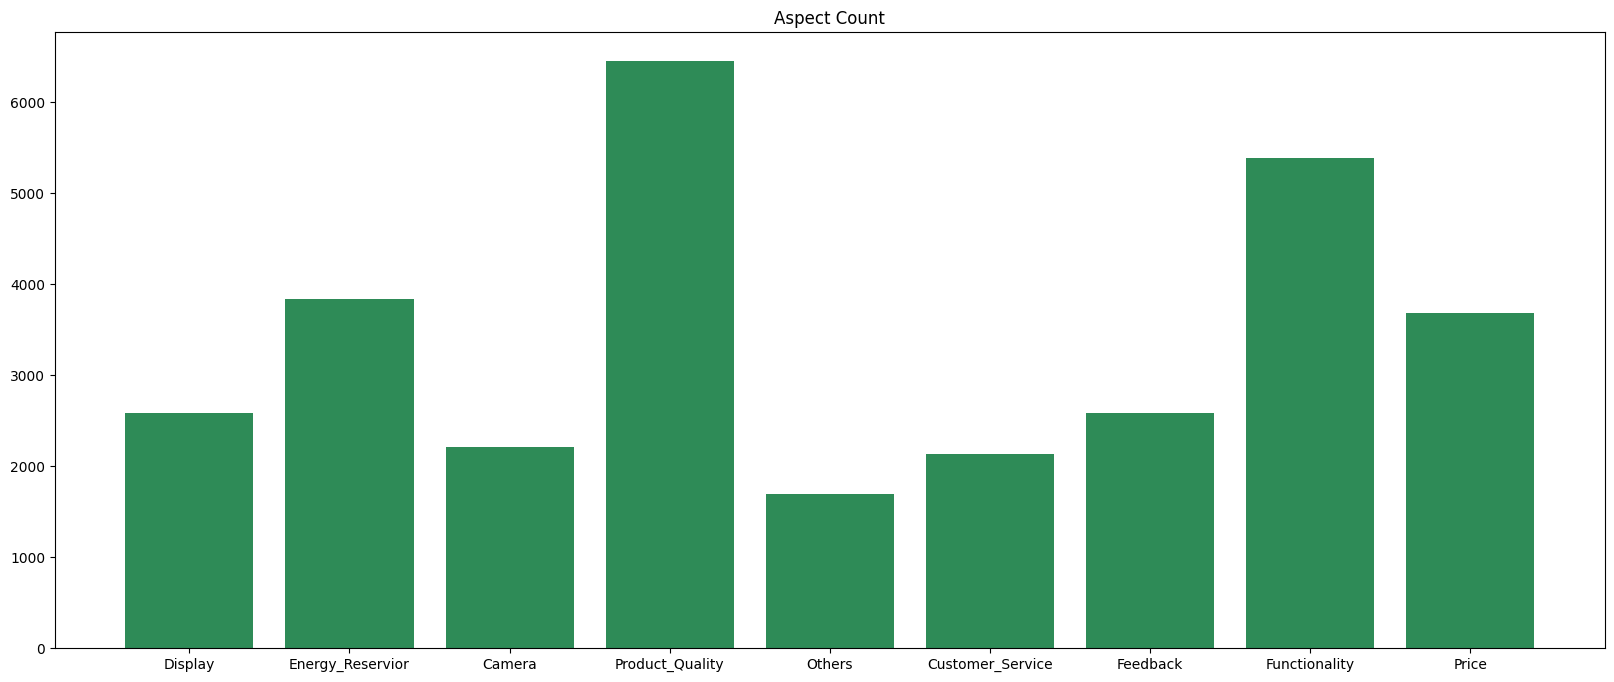

In [52]:
# %%
# plot the aspect_count in a vertical bar graph
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.bar(range(len(aspect_label_freqs)), list(aspect_label_freqs.values()), align='center',color='seagreen')
plt.xticks(range(len(aspect_label_freqs)), list(aspect_label_freqs.keys()))
plt.title('Aspect Count')
# Format the plt figure with sea green color
# plt.rcParams['figure.facecolor'] = 'xkcd:sea green'
# Make the bars in pink
plt.show()

In [53]:
# %%

# %%
aspect_label_final[0]

['Display', 'Energy_Reservior', 'Camera']

In [54]:
# %%
len(aspect_label_final)

13474

In [55]:
# %%
len(aspect_labels_count)
# 

9

In [56]:
print(len(complaint_labels))
print(len(aspect_label_final))
print(aspect_label_final[124])

13474
13474
['Product_Quality']


In [57]:
aspect_labels_count

['Functionality',
 'Price',
 'Customer_Service',
 'Camera',
 'Energy_Reservior',
 'Others',
 'Feedback',
 'Product_Quality',
 'Display']

In [58]:
# %%
# Create a list of list as the size of complaint_labels and one list in it should be of size 10 in which 1 is present at the index of the complaint label
complaint_labels_count = []
for i in range(len(complaint_labels)):
  temp = [0]*num_of_labels
  for j in range(num_of_labels):
    #print(i)
    if(aspect_label_final[i][0] == aspect_labels_count[j]):
      temp[j] = 1
    if(len(aspect_label_final[i]) > 1):
      if(aspect_label_final[i][1] == aspect_labels_count[j]):
        temp[j] = 1
    if(len(aspect_label_final[i]) > 2):
      if(aspect_label_final[i][2] == aspect_labels_count[j]):
        temp[j] = 1
  complaint_labels_count.append(temp)

In [59]:
# %%
import tensorflow as tf
# # comp_labels = list(pd.Series(comp_labels).fillna(0.))
# # complaint_labels_reshaped = tf.keras.utils.to_categorical(comp_labels)
# review_embeddings = np.array(review_embeddings).reshape(-1, 1, 768)

# import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# max_length = max(len(seq) for seq in review_embeddings)

# padded_review_embeddings = pad_sequences(review_embeddings, maxlen=max_length, padding='post', truncating='post', dtype='float32')

review_embeddings = np.array(review_embeddings).reshape(-1, 1, 768)
img_converted = tf.convert_to_tensor([tf.convert_to_tensor(i, dtype=tf.float32) for i in images], dtype = tf.float32)

2024-02-12 20:02:14.303619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 20:02:14.303645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [60]:
# %%
img_converted.shape

TensorShape([13474, 224, 224, 3])

In [61]:
review_embeddings.shape

(13474, 1, 768)

In [62]:
len(complaint_labels_count)

13474

In [63]:
# %%
complaint_labels_0 = [item[0] for item in complaint_labels]

In [64]:
# %%
RANDOM_SEED = 42
# First Split for Train and Test
img_train,img_test, x_train,x_test, y_train,y_test, comp_label_train,comp_label_test = train_test_split( np.array(img_converted),
                                                              np.array(review_embeddings), np.array(complaint_labels_count), np.array(complaint_labels_0),
                                                              test_size=0.1, random_state=RANDOM_SEED,shuffle=True)

# Next split Train in to training and validation
img_tr,img_val, x_tr,x_val, y_tr,y_val, comp_label_tr,comp_label_val = train_test_split(img_train, x_train, y_train,comp_label_train, test_size=0.2,
                                                          random_state = RANDOM_SEED,shuffle=True)

print(img_tr.shape)
print(img_test.shape)
print(img_val.shape)
print(x_tr.shape)
print(x_test.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_test.shape)
print(y_val.shape)

(9700, 224, 224, 3)
(1348, 224, 224, 3)
(2426, 224, 224, 3)
(9700, 1, 768)
(1348, 1, 768)
(2426, 1, 768)
(9700, 9)
(1348, 9)
(2426, 9)


In [65]:
# %% [markdown]
# ## Modeling

# %%
class AttLayer(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttLayer, self).__init__(** kwargs)

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
        }
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [66]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class AttLayer(nn.Module):
#     def __init__(self, input_dim, return_attention=False):
#         super(AttLayer, self).__init__()
#         self.return_attention = return_attention

#         # Initialize the learnable weight matrix
#         self.W = nn.Parameter(torch.Tensor(input_dim, 1))
#         nn.init.xavier_uniform_(self.W)  # You can use other initialization methods

#     def forward(self, x, mask=None):
#         # computes a probability distribution over the timesteps
#         # uses 'max trick' for numerical stability
#         logits = torch.matmul(x, self.W)
#         ai = torch.exp(logits - torch.max(logits, dim=-1, keepdim=True).values)

#         # masked timesteps have zero weight
#         if mask is not None:
#             ai = ai * mask
#         att_weights = ai / (torch.sum(ai, dim=1, keepdim=True) + 1e-8)
#         weighted_input = x * att_weights.unsqueeze(2)
#         result = torch.sum(weighted_input, dim=1)
#         if self.return_attention:
#             return result, att_weights
#         return result

#     def compute_mask(self, input, input_mask=None):
#         if isinstance(input_mask, list):
#             return [None] * len(input_mask)
#         else:
#             return None


In [67]:
# %%
import tensorflow as tf
import keras
from keras import layers

# %%

In [68]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
# import torchvision.models as models

# # Define ResNet152
# resnet152 = models.resnet152(pretrained=True)
# num_ftrs = resnet152.fc.in_features
# print(num_ftrs)
# resnet152 = nn.Sequential(*list(resnet152.children())[:-1])  # Remove the last fully connected layer

# # Freeze ResNet layers
# for param in resnet152.parameters():
#     param.requires_grad = False

In [69]:
# resnet152.eval()
# with torch.no_grad():
#     # Assuming img_tr[0] is a single image, you can add a batch dimension
#     input_image = torch.tensor(img_tr[0]).permute(2, 0, 1).unsqueeze(0)

#     # Pass the input through the ResNet model
#     output = resnet152(input_image)
#     print(output.shape)
#     output = output.squeeze(dim=2).squeeze(dim=2)
#     print(output.shape)
    


In [70]:
# import torch
# import torch.nn as nn

# class Sampling(nn.Module):
#     def forward(self, z_mean, z_log_var):
#         batch_size, dim = z_mean.size()
#         epsilon = torch.randn(batch_size, dim).to(z_mean.device)
#         return z_mean + torch.exp(0.5 * z_log_var) * epsilon


In [71]:
# # Define the model
# class VAE_GRU(nn.Module):
#     def __init__(self, num_labels, resnet152):
#         super(VAE_GRU, self).__init__()

#         # ResNet layer
#         self.resnet152 = resnet152
#         self.pooling_layer = nn.AdaptiveAvgPool2d((1, 1))
        
#         # Text and image features concatenation
#         self.img_repr_dense = nn.Linear(2048, 768)
#         self.concatenated_dense = nn.Linear(1536, 768)

#         self.relu = nn.ReLU()

#         self.encoder1 = nn.Linear(768, 256)
#         self.z_mean = nn.Linear(256, 128)
#         self.z_log_var = nn.Linear(256, 128)
        
#         self.sampling = Sampling()

#         # VAE Decoder
#         self.decoder_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 768)
#         )
#         self.input_1_dense = nn.Linear(768, 128)

#         # Linear layer
#         self.linear_layer = nn.Linear(896, 768)

#         # Bi-directional GRU
#         self.bi_lstm = nn.GRU(768, 256, bidirectional=True, batch_first=True, dropout=0.3)

#         self.att_layer = AttLayer(512)

#         # Final output layers
#         self.out_aspects_dense = nn.Sequential(
#             nn.Dropout(0.3),
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, num_labels),
#             nn.Sigmoid()
#         )

#     def forward(self, input_1, image_input):
#         # ResNet feature extraction
#         #print(image_input.shape)
#         resnet_output = self.resnet152(image_input)
#         pooling_output = self.pooling_layer(resnet_output)
#         img_repr = self.img_repr_dense(pooling_output.view(-1, 2048))

#         # Concatenate text and image features
#         #print(input_1.shape)
#         #print(img_repr.shape)
#         concatenated_features = torch.cat((input_1.squeeze(dim=1), img_repr), dim=1)
#         concatenated_features = self.concatenated_dense(concatenated_features)
#         #print(concatenated_features.shape)
#         # VAE Encoder
#         encoder_output = self.relu(self.encoder1(concatenated_features))
#         z_mean = self.z_mean(encoder_output)
#         z_log_var = self.z_log_var(encoder_output)
#         z = self.sampling(z_mean, z_log_var)

#         # VAE Decoder
#         decoder_output = self.decoder_dense(z)
#         #print(decoder_output.shape)
#         #decoder_output = decoder_output.view(-1, 1, 256)

#         #print(decoder_output.shape)

#         input_1 = input_1.squeeze()
#         #print(input_1.shape)

#         # Concatenate with input_1_dense for further processing
#         merged_features = torch.cat((self.input_1_dense(input_1), decoder_output), dim=-1)

#         # Linear layer
#         linear_output = self.linear_layer(merged_features)

#         # Bi-directional GRU
#         bi_lstm_output, _ = self.bi_lstm(linear_output)
#         # Attention layer
#         #print(bi_lstm_output.shape)
#         attention_output = self.att_layer(bi_lstm_output)

#         # Final output layers
#         out_aspects = self.out_aspects_dense(attention_output)

#         return out_aspects, linear_output, concatenated_features, z_mean, z_log_var

In [72]:
# device = torch.device("cpu")

In [73]:
# # Instantiate the model
# num_of_labels = 9  # Replace with the actual number of labels
# vae_gru_model = VAE_GRU(num_of_labels,resnet152)
# vae_gru_model = vae_gru_model.to(device)

# # Loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(vae_gru_model.parameters(), lr=1e-4)

In [74]:
# print(y_tr[0])

In [75]:
# print(img_tr.shape)

In [76]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Assuming x_tr, img_tr, y_tr, x_val, img_val, y_val are your training and validation data

# # Convert numpy arrays to PyTorch tensors
# x_tr_tensor = torch.Tensor(x_tr)
# img_tr_tensor = torch.Tensor(img_tr)
# print(img_tr_tensor.shape)
# img_tr_tensor = torch.tensor(img_tr_tensor).permute(0, 3, 1, 2)
# y_tr_tensor = torch.Tensor(y_tr)

# x_val_tensor = torch.Tensor(x_val)
# img_val_tensor = torch.Tensor(img_val)
# img_val_tensor = torch.tensor(img_val_tensor).permute(0, 3, 1, 2)
# y_val_tensor = torch.Tensor(y_val)

# # Create TensorDatasets
# train_dataset = TensorDataset(x_tr_tensor, img_tr_tensor, y_tr_tensor)
# val_dataset = TensorDataset(x_val_tensor, img_val_tensor, y_val_tensor)

# # Create DataLoader
# batch_size = 64
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


In [77]:
# model_name = "vae_gru.pt"
# min_val_loss = 100
# best_epoch = 0

In [78]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
# from torch.utils.data import DataLoader, TensorDataset

# # Assuming vae_gru_model, optimizer, train_loader, val_loader are defined

# # Training loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     vae_gru_model.train()
#     total_loss = 0.0
#     correct = 0
#     total_samples = 0

#     # Training
#     for text, image, labels in train_loader:
#         #print(image.shape)
#         #image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
#         #print(image.shape)
#         text, image, labels = text.to(device), image.to(device), labels.to(device)
#         outputs, linear_output, concatenated_features, z_mean, z_log_var = vae_gru_model.forward(text, image)

#         reconstruction_loss = nn.MSELoss()(concatenated_features, linear_output)

#         # KL Divergence Loss
#         kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

#         # Total Loss
#         vae_loss = reconstruction_loss + kl_loss

#         # Binary Cross-Entropy Loss
#         bce_loss = nn.BCEWithLogitsLoss()(outputs, labels)

#         # Combined Loss
#         combined_loss = bce_loss + 0.5 * vae_loss

#         loss = combined_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Update statistics
#         total_loss += loss.item()
#         #print(outputs[0])
#         # Apply threshold
#         threshold = 0.5
#         predicted_labels = (outputs > threshold).float()
        
#         # Calculate accuracy for each sample
#         accuracy_per_sample = (predicted_labels == labels).float()
        
#         # Calculate overall accuracy
#         overall_accuracy = accuracy_per_sample.mean().item()
#         # predicted, _ = torch.max(outputs, 1)
#         # print(predicted.shape)
#         correct += overall_accuracy
#         total_samples += labels.size(0)

#     # Print training statistics
#     avg_loss = total_loss / len(train_loader)
#     accuracy = correct / total_samples * 100
    
#     print(f"Epoch : {epoch+1}")
#     print(f"Training Loss : {avg_loss}")
#     print(f"Training Accuracy : {accuracy}")
#     print("")

#     # Validation loop
#     vae_gru_model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total_samples = 0

#     with torch.no_grad():
#         for val_text, val_image, val_labels in val_loader:
#             val_text, val_image, val_labels = val_text.to(device), val_image.to(device), val_labels.to(device)
#             val_outputs, val_linear_output, val_concatenated_features, _, _ = vae_gru_model(val_text, val_image)

#             val_reconstruction_loss = nn.MSELoss()(val_concatenated_features, val_linear_output)

#             # KL Divergence Loss
#             val_kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

#             # Total Loss
#             val_vae_loss = val_reconstruction_loss + val_kl_loss

#             # Binary Cross-Entropy Loss
#             val_bce_loss = nn.BCEWithLogitsLoss()(val_outputs, val_labels)

#             # Combined Loss
#             val_combined_loss = val_bce_loss + 0.5 * val_vae_loss

#             val_loss += val_combined_loss.item()
#             threshold = 0.5
#             predicted_labels = (val_outputs > threshold).float()
            
#             # Calculate accuracy for each sample
#             accuracy_per_sample = (predicted_labels == val_labels).float()
            
#             # Calculate overall accuracy
#             overall_accuracy = accuracy_per_sample.mean().item()
#             # predicted, _ = torch.max(outputs, 1)
#             # print(predicted.shape)
#             val_correct += overall_accuracy
#             val_total_samples += val_labels.size(0)
#             # _, val_predicted = torch.max(val_outputs, 1)
#             # val_correct += (val_predicted == val_labels).sum().item()
#             # val_total_samples += val_labels.size(0)

#     # Print validation statistics
#     avg_val_loss = val_loss / len(val_loader)
#     val_accuracy = val_correct / val_total_samples * 100

#     if ((min_val_loss - avg_val_loss) > 1e-4):
#         min_val_loss = avg_val_loss
#         best_epoch = epoch+1
#         torch.save(vae_gru_model.state_dict(), model_name)

#     print(f"Epoch : {epoch+1}")
#     print(f"Validation Loss : {avg_val_loss}")
#     print(f"Validation Accuracy : {val_accuracy}")
#     print("")
    
#     vae_gru_model.load_state_dict(torch.load(model_name))
    
#     #print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


In [79]:
# import torch

# # Example outputs and labels
# outputs = torch.tensor([8.9438e-02, 3.2532e-03, 9.6539e-01, 1.6857e-02, 5.0016e-01, 3.4694e-02,
#                         5.4462e-04, 9.5172e-01, 6.2582e-03], requires_grad=True)
# labels = torch.tensor([0, 1, 1, 0, 0, 0, 1, 1, 1], dtype=torch.float32)

# # Apply threshold
# threshold = 0.5
# predicted_labels = (outputs > threshold).float()

# # Calculate accuracy for each sample
# accuracy_per_sample = (predicted_labels == labels).float()

# # Calculate overall accuracy
# overall_accuracy = accuracy_per_sample.mean().item()

# print("Predicted Labels:", predicted_labels)
# print("True Labels:", labels)
# print("Accuracy per sample:", accuracy_per_sample)
# print("Overall Accuracy:", overall_accuracy)


In [91]:
resnet152 = ResNet152(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in resnet152.layers:
    layer.trainable = False
input_1 = Input(shape=(1, 768), dtype='float32')
image_input = Input(shape=(224, 224, 3), name='Images_input')
resnet152_output = resnet152(image_input)
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(resnet152_output)
img_repr = (tf.reshape(pooling_layer, [-1, 1, 2048]))
# Add a dense layer to the pooled feature representation to make it the same shape as input_1
img_repr = Dense(768, activation = 'relu')(img_repr)

# Concatenate text and image features
concatenated_features = layers.Concatenate(axis=1)([input_1, img_repr])
# concatenated_features = input_1
# concatenated_features = img_repr
# TODO Uncomment the below line
concatenated_features = Dense(768, activation = 'relu')(concatenated_features)
concatenated_features = layers.Flatten()(concatenated_features)
# # VAE Encoder
# encoder_inputs = concatenated_features
# x = layers.Flatten()(encoder_inputs)
# x = layers.Dense(256, activation="relu")(x)
# z_mean = layers.Dense(128, name="z_mean")(x)
# z_log_var = layers.Dense(128, name="z_log_var")(x)

# # Sampling layer
# class Sampling(layers.Layer):
#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# z = Sampling()([z_mean, z_log_var])

# # VAE Decoder
# decoder_inputs = z
# x = layers.Dense(256, activation="relu")(decoder_inputs)
# x = layers.Reshape((1, 256))(x)

# input_1_dense = layers.Dense(128, name="input_1_dense")(input_1)
# # Concatenate with img_repr for further processing
# # TODO Uncomment the below line
# merged_features = layers.Concatenate(axis=-1)([input_1_dense, x])
# # merged_features = x

# # Linear layer
# linear_layer = layers.Dense(768)(merged_features)


# Bi_lstm = Bidirectional(tf.keras.layers.GRU(256, return_sequences = True, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer = l2(0.000001)))(concatenated_features)
# Bi_lstm = AttLayer()(Bi_lstm)
out_aspects = Dropout(0.3)(concatenated_features)
out_aspects = Dense(128, activation = 'relu')(out_aspects)
out_aspects = Dropout(0.2)(out_aspects)
output = Dense(9, activation = 'sigmoid')(out_aspects)

MM_model = Model([input_1, image_input], output)
MM_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Images_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet152 (Functional)      (None, 7, 7, 2048)           5837094   ['Images_input[0][0]']        
                                                          4                                       
                                                                                                  
 global_average_pooling2d_1  (None, 2048)                 0         ['resnet152[0][0]']           
  (GlobalAveragePooling2D)                                                                        
                                                                                            

In [92]:
# %%
from keras.layers import Input, Dense, Flatten, Concatenate, Attention

# %%
# %pip install tensorflow-addons

# %%
# import tensorflow_addons as tfa
# from tensorflow import keras

In [93]:
# %%
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [94]:
# %%
def asymmetric_loss(gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
    def loss(y_true, y_pred):
        # Calculating Probabilities
        y_true = tf.cast(y_true, tf.float32)
        y_pred_sigmoid = tf.sigmoid(y_pred)
        y_pred_pos = y_pred_sigmoid
        y_pred_neg = 1 - y_pred_sigmoid

        # Asymmetric Clipping
        if clip is not None and clip > 0:
            y_pred_neg = tf.clip_by_value(y_pred_neg + clip, clip_value_min=0.0, clip_value_max=1.0)

        # Basic CE calculation
        los_pos = y_true * tf.math.log(tf.clip_by_value(y_pred_pos, eps, 1.0))
        los_neg = (1 - y_true) * tf.math.log(tf.clip_by_value(y_pred_neg, eps, 1.0))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if gamma_neg > 0 or gamma_pos > 0:
            pt0 = y_pred_pos * y_true
            pt1 = y_pred_neg * (1 - y_true)
            pt = pt0 + pt1
            one_sided_gamma = gamma_pos * y_true + gamma_neg * (1 - y_true)
            one_sided_w = tf.pow(1 - pt, one_sided_gamma)
            loss *= one_sided_w

        return -tf.reduce_sum(loss)

    return loss

In [95]:
# %%
def asymmetric_loss(gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
    def loss(y_true, y_pred):
        # Calculating Probabilities
        y_true = tf.cast(y_true, tf.float32)
        y_pred_sigmoid = tf.sigmoid(y_pred)
        y_pred_pos = y_pred_sigmoid
        y_pred_neg = 1 - y_pred_sigmoid

        # Asymmetric Clipping
        if clip is not None and clip > 0:
            y_pred_neg = tf.clip_by_value(y_pred_neg + clip, clip_value_min=0.0, clip_value_max=1.0)

        # Basic CE calculation
        los_pos = y_true * tf.math.log(tf.clip_by_value(y_pred_pos, eps, 1.0))
        los_neg = (1 - y_true) * tf.math.log(tf.clip_by_value(y_pred_neg, eps, 1.0))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if gamma_neg > 0 or gamma_pos > 0:
            pt0 = y_pred_pos * y_true
            pt1 = y_pred_neg * (1 - y_true)
            pt = pt0 + pt1
            one_sided_gamma = gamma_pos * y_true + gamma_neg * (1 - y_true)
            one_sided_w = tf.pow(1 - pt, one_sided_gamma)
            loss *= one_sided_w

        return -tf.reduce_sum(loss)

    return loss

In [96]:
# Flatten the image_input to match the shape of linear_layer
flat_image_input = tf.keras.layers.Flatten()(image_input)

In [97]:
print(image_input.shape)

(None, 224, 224, 3)


In [98]:
print(flat_image_input.shape)

(None, 150528)


In [99]:
# # Reconstruction Loss
# reconstruction_loss = tf.keras.losses.mean_squared_error(concatenated_features, linear_layer)


# # KL Divergence Loss
# kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

# # Total Loss
# vae_loss = reconstruction_loss + kl_loss

# combined_loss = lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred) + 0.5 * vae_loss
# # # Combine VAE loss with binary cross-entropy loss
# # final_loss = 'binary_crossentropy' + 0.5 * vae_loss  # Adjust the weight as needed

# # MM_model.add_loss(final_loss)

# # Compile the model
# MM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss,
#                   metrics=['accuracy'])

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13, verbose=1, restore_best_weights=True)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath="./save_dir",
#     save_weights_only=False,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# # Modify the fit method to include both inputs and outputs
# MM_model.fit(
#     [x_tr, img_tr], y_tr,
#     batch_size=16,
#     epochs=50,
#     validation_data=([x_val, img_val], y_val),
#     steps_per_epoch=x_tr.shape[0] // 16,
#     validation_steps=x_val.shape[0] // 16,
#     shuffle=True,
#     verbose=1,
#     callbacks=[earlystopping, model_checkpoint_callback]
# )

In [100]:
m = 'accuracy'
MM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss = 'binary_crossentropy',
                  loss_weights = 0.5,
                  metrics = m)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13, verbose=1, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./save_dir",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

MM_model.fit(
    [x_tr, img_tr], y_tr,
    batch_size=16,
    epochs=50,
    validation_data = ([x_val, img_val], y_val),
    steps_per_epoch = x_tr.shape[0] // 16,
    validation_steps = x_val.shape[0] // 16,
    shuffle=True,
    verbose=1,
    callbacks=[earlystopping, model_checkpoint_callback]
)

Epoch 1/50


2024-02-12 20:16:02.938079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-12 20:16:03.229964: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


606/606 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.3164INFO:tensorflow:Assets written to: ./save_dir/assets


INFO:tensorflow:Assets written to: ./save_dir/assets


606/606 [==============================] - 171s 276ms/step - loss: 0.2220 - accuracy: 0.3164 - val_loss: 0.1911 - val_accuracy: 0.3738
Epoch 2/50
606/606 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.4865INFO:tensorflow:Assets written to: ./save_dir/assets


INFO:tensorflow:Assets written to: ./save_dir/assets


606/606 [==============================] - 165s 271ms/step - loss: 0.1741 - accuracy: 0.4865 - val_loss: 0.1603 - val_accuracy: 0.4839
Epoch 3/50
606/606 [==============================] - 149s 246ms/step - loss: 0.1513 - accuracy: 0.5284 - val_loss: 0.1459 - val_accuracy: 0.4350
Epoch 4/50
606/606 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.5407INFO:tensorflow:Assets written to: ./save_dir/assets


INFO:tensorflow:Assets written to: ./save_dir/assets


606/606 [==============================] - 167s 275ms/step - loss: 0.1356 - accuracy: 0.5407 - val_loss: 0.1286 - val_accuracy: 0.5488
Epoch 5/50
606/606 [==============================] - 148s 245ms/step - loss: 0.1229 - accuracy: 0.5508 - val_loss: 0.1205 - val_accuracy: 0.4988
Epoch 6/50
606/606 [==============================] - 147s 243ms/step - loss: 0.1126 - accuracy: 0.5635 - val_loss: 0.1117 - val_accuracy: 0.4830
Epoch 7/50
606/606 [==============================] - 148s 244ms/step - loss: 0.1039 - accuracy: 0.5699 - val_loss: 0.1040 - val_accuracy: 0.5348
Epoch 8/50
606/606 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.5781INFO:tensorflow:Assets written to: ./save_dir/assets


INFO:tensorflow:Assets written to: ./save_dir/assets


606/606 [==============================] - 166s 274ms/step - loss: 0.0955 - accuracy: 0.5781 - val_loss: 0.0977 - val_accuracy: 0.5513
Epoch 9/50
606/606 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.5757INFO:tensorflow:Assets written to: ./save_dir/assets


INFO:tensorflow:Assets written to: ./save_dir/assets


606/606 [==============================] - 171s 282ms/step - loss: 0.0890 - accuracy: 0.5757 - val_loss: 0.0909 - val_accuracy: 0.5919
Epoch 10/50
606/606 [==============================] - 298s 492ms/step - loss: 0.0827 - accuracy: 0.5822 - val_loss: 0.0833 - val_accuracy: 0.5687
Epoch 11/50
606/606 [==============================] - 148s 244ms/step - loss: 0.0773 - accuracy: 0.5826 - val_loss: 0.0820 - val_accuracy: 0.5145
Epoch 12/50
606/606 [==============================] - 148s 245ms/step - loss: 0.0720 - accuracy: 0.5821 - val_loss: 0.0765 - val_accuracy: 0.5161
Epoch 13/50
606/606 [==============================] - 148s 245ms/step - loss: 0.0676 - accuracy: 0.5749 - val_loss: 0.0718 - val_accuracy: 0.5530
Epoch 14/50
606/606 [==============================] - 149s 246ms/step - loss: 0.0640 - accuracy: 0.5747 - val_loss: 0.0685 - val_accuracy: 0.5199
Epoch 15/50
606/606 [==============================] - 148s 244ms/step - loss: 0.0598 - accuracy: 0.5791 - val_loss: 0.0640 - val_

In [101]:
# %%
MM_model.save('multi_aspect_detection_text_image.h5')

# %%
# MM_model = load_model('multi_aspect_detection_text_image.h5', custom_objects={'AttLayer': AttLayer})
# MM_model = load_model('./save_dir')

/Users/apple/anaconda3/envs/ml1/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [102]:
img_test.shape

(1348, 224, 224, 3)

In [103]:
# %%
complaint_labels_predicted = MM_model.predict([x_test, img_test])
complaint_labels_pred = np.argmax(complaint_labels_predicted, axis = -1)
complaint_labels_predicted

43/43 [==============================] - 19s 389ms/step


array([[1.5150799e-03, 3.3400913e-03, 9.3540823e-01, ..., 8.1557137e-01,
        3.3892454e-03, 9.2685646e-01],
       [9.8224926e-01, 1.6528581e-01, 2.7155945e-02, ..., 1.4257499e-02,
        8.9979112e-01, 1.7977157e-01],
       [4.0961127e-03, 1.9203421e-03, 6.0579870e-02, ..., 8.6609095e-01,
        2.8786099e-01, 3.1148689e-02],
       ...,
       [8.8545823e-01, 4.0046750e-03, 6.3461415e-02, ..., 3.7316460e-02,
        9.0594357e-01, 1.6744392e-03],
       [7.9646579e-04, 4.5469748e-03, 5.8857986e-04, ..., 6.3765228e-01,
        1.0474985e-02, 9.7019672e-02],
       [2.7512160e-01, 8.5529214e-01, 2.6171589e-01, ..., 2.0553301e-04,
        8.8623613e-01, 4.5473427e-02]], dtype=float32)

In [107]:
# %%
threshold = 0.5
y_pred = [np.where(prob >= threshold, 1, 0) for prob in complaint_labels_predicted]

In [108]:
# %%
y_test

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [109]:
# %%
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5853115727002968


In [110]:
# %%
aspect_labels_count[1] = "No Aspect"

In [111]:
# %%
print(classification_report(y_test, y_pred, target_names=aspect_labels_count))

                  precision    recall  f1-score   support

   Functionality       0.96      0.87      0.91       465
       No Aspect       0.80      0.92      0.86       352
Customer_Service       0.87      0.82      0.85       205
          Camera       0.90      0.91      0.91       215
Energy_Reservior       0.92      0.84      0.88       365
          Others       0.92      0.81      0.86       152
        Feedback       0.88      0.50      0.64       246
 Product_Quality       0.81      0.91      0.86       665
         Display       0.97      0.65      0.78       277

       micro avg       0.88      0.83      0.85      2942
       macro avg       0.89      0.80      0.84      2942
    weighted avg       0.89      0.83      0.85      2942
     samples avg       0.84      0.82      0.81      2942



/Users/apple/anaconda3/envs/ml1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# %%
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

mcm = multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
# %%
fig, axes = plt.subplots(1, len(mcm), figsize=(20, 2))
for i, (label, cm) in enumerate(zip(aspect_labels_count, mcm)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    # axes[i].set_xlabel('Predicted')
    # axes[i].set_ylabel('True')
    axes[i].set_title(f'{label}')
# plt.tight_layout()
plt.show()

In [ ]:
# %%
ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
# %%
domain_list = list(dataset['Domain'])
(domain_list)

In [ ]:
# %%
x_test_domain = []
img_test_domain = []
y_test_domain = []
for i in range(len(domain_list)):
    if domain_list[i] == 'Mobile':
        # print("adding")
        x_test_domain.append(review_embeddings[i])
        img_test_domain.append(img_converted[i])
        y_test_domain.append(complaint_labels_count[i])
complaint_labels_predicted_domain = MM_model.predict([np.array(x_test_domain), np.array(img_test_domain)])
y_pred_domain = [np.where(prob >= threshold, 1, 0) for prob in complaint_labels_predicted_domain]
accuracy = accuracy_score(np.array(y_test_domain), np.array(y_pred_domain))
print(accuracy)
print(classification_report(np.array(y_test_domain), np.array(y_pred_domain), target_names=aspect_labels_count))
        
        

In [ ]:
# %%
domain = []
for i in dataset['Domain']:
    domain.append(i.strip().lower())
domain = list(domain)
from collections import Counter
domain_counter = Counter(domain)
print(domain_counter)

In [ ]:
# %%
# Code for ignoring warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# %%
for domain in domain_count.keys():
    x_test_domain = []
    img_test_domain = []
    y_test_domain = []
    for i in range(len(domain_list)):
        if domain_list[i].lower().strip() == domain:
            # print("adding")
            x_test_domain.append(review_embeddings[i])
            img_test_domain.append(img_converted[i])
            y_test_domain.append(complaint_labels_count[i])
    complaint_labels_predicted_domain = MM_model.predict([np.array(x_test_domain), np.array(img_test_domain)])
    y_pred_domain = [np.where(prob >= threshold, 1, 0) for prob in complaint_labels_predicted_domain]
    accuracy = accuracy_score(np.array(y_test_domain), np.array(y_pred_domain))
    print(domain)
    print(accuracy)
    print(classification_report(np.array(y_test_domain), np.array(y_pred_domain), target_names=aspect_labels_count))
        
        

In [ ]:
# %%
complaint_labels_predicted = MM_model.predict([np.array(review_embeddings), np.array(img_converted)])
complaint_labels_pred = np.argmax(complaint_labels_predicted, axis = -1)
complaint_labels_predicted

In [ ]:
# %%
threshold = 0.5
y_pred = [np.where(prob >= threshold, 1, 0) for prob in complaint_labels_predicted]

In [ ]:
# %%
accuracy = accuracy_score(np.array(complaint_labels_count), y_pred)
print(accuracy)

In [ ]:
# %%
print(classification_report(np.array(complaint_labels_count), y_pred, target_names=aspect_labels_count))